In [ ]:
!apt update
!apt install -y graphviz libgraphviz-dev pkg-config

In [44]:
# @title Installations
!pip install -q langgraph==0.3.31 langchain-openai
!pip install -q langchain==0.3.23
!pip install -q langchain_community==0.3.21
%pip install -q pygraphviz==1.14

## Workflow of Reflection Agent in LangGraph:

1. **Generation Node: Generate Initial Output**
   - The first step in the process is the **generation node**, which quickly produces an initial output based on the given prompt. This stage is all about generating a first draft without focusing too much on perfection. It acts like an instinctive response, providing a rough version of the output. For example, if the task is to write a LinkedIn post, the generation node would come up with a basic idea. This draft is then passed to the next step for evaluation.
     
<br>

2. **Evaluation Node: Evaluate Output for Quality**
   - After the initial output is generated, the **evaluation node** assesses its quality. This step is about checking if the output is good enough or if it needs improvement. The evaluation focuses on key aspects like whether the message is clear, engaging, and relevant. For instance, in the case of a LinkedIn post, the evaluation might decide if the post feels authentic, aligns with professional tone, or misses important context. If the output is deemed acceptable, it moves forward to the final step.

<br>

3. **Reflection Node: Critique and Refine**
   - If the evaluation node determines that the output needs improvement, the **reflection node** steps in to refine the content. This step is more thoughtful and deliberate, where the system reflects on the output and looks for ways to improve it. The reflection node critiques the draft, suggests changes, and revises the content to make it more polished. It could involve enhancing tone, adding clarity, highlighting achievements, or making the post more engaging. The system keeps refining the output through this process until it reaches the desired quality level.
     
<br>

4. **Final Output: Present Refined Result**
   - Once the reflection node has done its job, the final output is produced. This is the result of the reflection and evaluation processes, where the initial draft has been refined and improved. The agent now presents the final version of the content — a polished, high-quality LinkedIn post ready for publishing. After this step, the process concludes, and the final response is delivered to the user.


---

**Example (LinkedIn Post Generation):**  
Imagine asking an AI to write a LinkedIn post announcing a job promotion:  

**Prompt:**  
"Write a LinkedIn post announcing my promotion to Engineering Manager."  

**AI’s Initial Output (System 1):**  
*"Excited to share that I’ve been promoted to Engineering Manager!"*  

**Reflection Step:**  
The AI reviews the post and asks:  
*"Does this post highlight leadership growth or express gratitude?"*  

**Refined Output (System 2):**  
*"I'm thrilled to share that I've been promoted to Engineering Manager at [Company]! Grateful for the mentorship, team collaboration, and opportunities that led to this moment. Looking forward to leading new initiatives and continuing to grow with this incredible team. #Leadership #CareerGrowth #EngineeringManager"*

---


In [19]:
# @title Imports
from langchain_openai import ChatOpenAI
from google.colab import userdata

from typing import List, Sequence, Annotated, TypedDict
from langchain.schema import HumanMessage, AIMessage, SystemMessage
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


In [10]:
# @title API Disclaimer
api_key =userdata.get('OPENAI_API_KEY')
llm = ChatOpenAI(model = 'gpt-4o-mini', openai_api_key = api_key)

In [14]:
# @title Generation Prompt
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a professional LinkedIn content assistant tasked with crafting engaging, insightful, and well-structured LinkedIn posts."
            " Generate the best LinkedIn post possible for the user's request."
            " If the user provides feedback or critique, respond with a refined version of your previous attempts, improving clarity, tone, or engagement as needed.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [15]:
# @title Generate Chain

generate_chain = generation_prompt | llm

In [16]:
# @title Reflection Prompt
reflection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a professional LinkedIn content strategist and thought leadership expert. Your task is to critically evaluate the given LinkedIn post and provide a comprehensive critique. Follow these guidelines:

        1. Assess the post’s overall quality, professionalism, and alignment with LinkedIn best practices.
        2. Evaluate the structure, tone, clarity, and readability of the post.
        3. Analyze the post’s potential for engagement (likes, comments, shares) and its effectiveness in building professional credibility.
        4. Consider the post’s relevance to the author’s industry, audience, or current trends.
        5. Examine the use of formatting (e.g., line breaks, bullet points), hashtags, mentions, and media (if any).
        6. Evaluate the effectiveness of any call-to-action or takeaway.

        Provide a detailed critique that includes:
        - A brief explanation of the post’s strengths and weaknesses.
        - Specific areas that could be improved.
        - Actionable suggestions for enhancing clarity, engagement, and professionalism.

        Your critique will be used to improve the post in the next revision step, so ensure your feedback is thoughtful, constructive, and practical.
        """
    ),
    MessagesPlaceholder(variable_name="messages")
])

In [18]:
# @title Reflect Chain

reflect_chain = reflection_prompt | llm

In [20]:
from langgraph.graph import MessageGraph

# Initialize a predefined MessageGraph
graph = MessageGraph()

/tmp/ipython-input-2960337801.py:4: LangGraphDeprecatedSinceV10: MessageGraph is deprecated in LangGraph v1.0.0, to be removed in v2.0.0. Please use StateGraph with a `messages` key instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  graph = MessageGraph()


In [21]:
def generation_node(state: Sequence[BaseMessage]) -> List[BaseMessage]:
    generated_post = generate_chain.invoke({"messages": state})
    return [AIMessage(content=generated_post.content)]

In [22]:
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    res = reflect_chain.invoke({"messages": messages})  # Passes messages as input to reflect_chain
    return [HumanMessage(content=res.content)]  # Returns the refined message as HumanMessage for feedback

In [23]:
graph.add_node("generate", generation_node)
graph.add_node("reflect", reflection_node)
graph.set_entry_point("generate")

In [82]:
def should_continue_4(state: List[BaseMessage]):
    print(state)
    print(len(state))
    print("----------------------------------------------------------------------")
    if len(state) > 6:
        return END
    return "reflect"

In [83]:
graph.add_conditional_edges("generate", should_continue_4)

In [84]:
workflow = graph.compile()

In [85]:
inputs = HumanMessage(content="""Write a linkedin post on getting a software developer job at IBM under 160 characters""")

In [86]:
response = workflow.invoke(inputs)

[HumanMessage(content='Write a linkedin post on getting a software developer job at IBM under 160 characters', additional_kwargs={}, response_metadata={}, id='17dc9260-4a49-4222-b9b5-9eb9e6901549'), AIMessage(content='Thrilled to share that I landed a software developer role at IBM! Excited for new challenges and to innovate at a company that shapes technology. 🚀 #IBM #SoftwareDevelopment', additional_kwargs={}, response_metadata={}, id='c4bb07fd-6aa0-482f-ad7c-374a742fb238')]
2
----------------------------------------------------------------------
[HumanMessage(content='Write a linkedin post on getting a software developer job at IBM under 160 characters', additional_kwargs={}, response_metadata={}, id='17dc9260-4a49-4222-b9b5-9eb9e6901549'), AIMessage(content='Thrilled to share that I landed a software developer role at IBM! Excited for new challenges and to innovate at a company that shapes technology. 🚀 #IBM #SoftwareDevelopment', additional_kwargs={}, response_metadata={}, id='c4b

In [90]:
response[0].content

'Write a linkedin post on getting a software developer job at IBM under 160 characters'

In [87]:
response[1].content

'Thrilled to share that I landed a software developer role at IBM! Excited for new challenges and to innovate at a company that shapes technology. 🚀 #IBM #SoftwareDevelopment'

In [88]:
response[2].content

'### Critique of the LinkedIn Post\n\n#### Overall Quality and Professionalism\nThe post is concise, fitting within the 160-character limit while effectively conveying excitement about the new job opportunity at IBM. It maintains a professional tone that\'s appropriate for LinkedIn, where career accomplishments are often shared.\n\n#### Structure, Tone, Clarity, and Readability\n- **Structure**: The post is straightforward, starting with the declaration of the achievement and followed by a brief expression of excitement. The use of an emoji adds a touch of personality without detracting from professionalism.\n- **Tone**: The tone is positive and enthusiastic, which can resonate well with LinkedIn users looking for motivation.\n- **Clarity**: The message is clear and easily understandable, although it could provide more context on what the author hopes to achieve in this role or why they are excited about it.\n\n#### Engagement Potential\nThe post\'s brevity and clarity may attract like

In [89]:
response[-1].content

'### Critique of the LinkedIn Post\n\n#### Overall Quality and Professionalism\nThe post is concise, fitting within the 160-character limit while effectively conveying excitement about the new job opportunity at IBM. It maintains a professional tone that\'s appropriate for LinkedIn, where career accomplishments are often shared.\n\n#### Structure, Tone, Clarity, and Readability\n- **Structure**: The post is straightforward, starting with the declaration of the achievement and followed by a brief expression of excitement. The use of an emoji adds a touch of personality without detracting from professionalism.\n- **Tone**: The tone is positive and enthusiastic, which can resonate well with LinkedIn users looking for motivation.\n- **Clarity**: The message is clear and easily understandable, although it could provide more context on what the author hopes to achieve in this role or why they are excited about it.\n\n#### Engagement Potential\nThe post\'s brevity and clarity may attract like

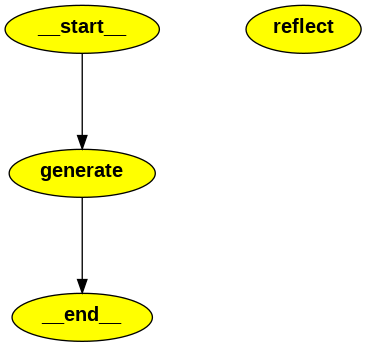

In [81]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_png()))